### pytorch-tabnet
* good result for single model, fixed split train/valid

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

from pytorch_tabnet.tab_model import TabNetRegressor

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# globals
FIGSIZE = (9, 6)

SEED = 42

FILE_TRAIN = "train.csv"

In [3]:
#
# my split in train, test set
#
def my_train_test_split(df, frac):
    # frac: the fraction used for train
    # df: the dataframe

    # shuffle before split
    df = df.sample(frac=1.0, random_state=SEED)

    # FRAC = 0.90
    tot_rec = df.shape[0]
    NUM_TRAIN = int(frac * tot_rec)
    NUM_TEST = tot_rec - NUM_TRAIN

    data_train = df[:NUM_TRAIN]
    data_test = df[NUM_TRAIN:]

    print()
    print("Numero totale di campioni:", tot_rec)
    print("Numero di campioni nel TRAIN SET:", data_train.shape[0])
    print("Numero di campioni nel Validation SET:", data_test.shape[0])

    return data_train, data_test

In [4]:
data_orig = pd.read_csv(FILE_TRAIN)

# feature engineering
data_orig["datetime"] = pd.to_datetime(data_orig["datetime"])

# this way I add 3 engineered features
data_orig["hour"] = data_orig["datetime"].dt.hour

# mese di fatto è duplicato di season. rimuovo
# data_orig['month'] = data_orig['datetime'].dt.month
# data_orig['day'] = data_orig['datetime'].dt.day
data_orig["year"] = data_orig["datetime"].dt.year

In [5]:
data_orig.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,year
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,19,2012
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,20,2012
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,21,2012
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,22,2012
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88,23,2012


In [6]:
all_columns = data_orig.columns

# colonne da ignorare
# atemp and temp are strongly correlated (0.98) taking only one
del_columns = ["datetime", "casual", "registered", "temp"]

TARGET = "count"

cat_cols = ["season", "holiday", "workingday", "weather", "hour", "year"]

num_cols = list(set(all_columns) - set([TARGET]) - set(del_columns) - set(cat_cols))

features = sorted(cat_cols + num_cols)

print("Tutte le colonne:", len(all_columns))
print("Colonne ignorate:", len(del_columns))
print("target:", len([TARGET]))
print("Colonne cat:", len(cat_cols))
print("Colonne num:", len(num_cols))
print("Num. features", len(features))

Tutte le colonne: 14
Colonne ignorate: 4
target: 1
Colonne cat: 6
Colonne num: 3
Num. features 9


In [7]:
data_used = data_orig.drop(del_columns, axis=1)

In [8]:
FRAC = 0.90

data_train, data_valid = my_train_test_split(data_used, frac=FRAC)


Numero totale di campioni: 10886
Numero di campioni nel TRAIN SET: 9797
Numero di campioni nel Validation SET: 1089


In [9]:
categorical_columns = cat_cols
categorical_dims = {}
vet_lenc = []

for col in cat_cols:
    print(col, data_train[col].nunique(), data_train[col].unique())
    l_enc = LabelEncoder()
    data_train[col] = l_enc.fit_transform(data_train[col].values)
    data_valid[col] = l_enc.transform(data_valid[col].values)
    vet_lenc.append(l_enc)
    categorical_dims[col] = len(l_enc.classes_)

season 4 [3 1 4 2]
holiday 2 [0 1]
workingday 2 [1 0]
weather 4 [1 2 3 4]
hour 24 [11  6 18 10 23 21 15  8  4  1  2 13  5 22 14  9 19 12 17  7 20  3 16  0]
year 2 [2011 2012]


In [10]:
cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [
    categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns
]

In [11]:
# separo X ed y
x_train = data_train[features].values
y_train = data_train[TARGET].values

y_train = y_train.reshape(-1, 1)

x_valid = data_valid[features].values
y_valid = data_valid[TARGET].values

y_valid = y_valid.reshape(-1, 1)

In [33]:
%%time

params = {"n_steps": 2, "cat_dims": cat_dims, "cat_idxs": cat_idxs, "verbose": 50}

# clf = TabNetRegressor(n_steps = 2, cat_dims=cat_dims, cat_idxs=cat_idxs, verbose=50)
clf = TabNetRegressor(**params)

# provo a cercare rmsle
clf.fit(
    x_train,
    y_train,
    eval_set=[(x_valid, y_valid)],
    eval_metric=["rmse", "rmsle"],
    max_epochs=1000,
    patience=100,
    batch_size=256,
)

Device used : cuda
epoch 0  | loss: 64465.50031| val_0_rmse: 220.24196| val_0_rmsle: 3.88671 |  0:00:01s
epoch 50 | loss: 3370.09716| val_0_rmse: 66.69998| val_0_rmsle: 0.43369 |  0:00:50s
epoch 100| loss: 3240.95082| val_0_rmse: 54.33304| val_0_rmsle: 0.43426 |  0:01:42s
epoch 150| loss: 2729.40119| val_0_rmse: 54.04931| val_0_rmsle: 0.36427 |  0:02:32s
epoch 200| loss: 2485.05472| val_0_rmse: 52.03079| val_0_rmsle: 0.33168 |  0:03:22s
epoch 250| loss: 2359.88666| val_0_rmse: 49.45926| val_0_rmsle: 0.30963 |  0:04:12s
epoch 300| loss: 2420.63225| val_0_rmse: 52.40608| val_0_rmsle: 0.27647 |  0:05:02s
epoch 350| loss: 2224.78907| val_0_rmse: 47.80612| val_0_rmsle: 0.27594 |  0:05:52s
epoch 400| loss: 2091.58225| val_0_rmse: 49.51025| val_0_rmsle: 0.27537 |  0:06:42s
epoch 450| loss: 2204.85994| val_0_rmse: 52.88376| val_0_rmsle: 0.41207 |  0:07:32s
epoch 500| loss: 2075.79942| val_0_rmse: 54.05765| val_0_rmsle: 0.32837 |  0:08:22s

Early stopping occurred at epoch 512 with best_epoch =

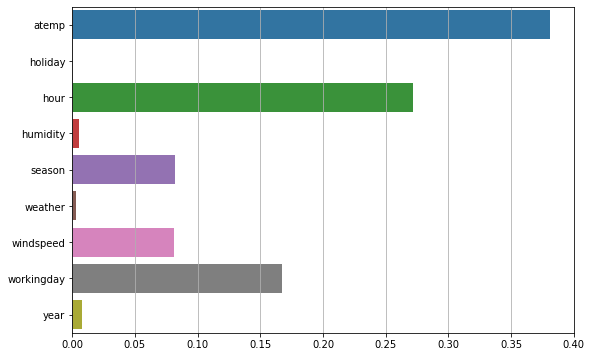

In [34]:
%matplotlib inline

# eXplainability: Feature importance


plt.figure(figsize=FIGSIZE)
plt.grid(True)
sns.barplot(x=clf.feature_importances_, y=features);

### Submission

In [35]:
test_orig = pd.read_csv("test.csv")

In [36]:
# add engineered features
# feature engineering
test_orig["datetime"] = pd.to_datetime(test_orig["datetime"])

# this way I add 3 engineered features
test_orig["hour"] = test_orig["datetime"].dt.hour
# test_orig['month'] = test_orig['datetime'].dt.month
# test_orig['day'] = test_orig['datetime'].dt.day
test_orig["year"] = test_orig["datetime"].dt.year

In [37]:
# code categorical
for i, col in enumerate(cat_cols):
    print(col, test_orig[col].nunique(), test_orig[col].unique())
    l_enc = vet_lenc[i]
    test_orig[col] = l_enc.transform(test_orig[col].values)

season 4 [1 2 3 4]
holiday 2 [0 1]
workingday 2 [1 0]
weather 4 [1 2 3 4]
hour 24 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
year 2 [2011 2012]


In [38]:
v_test = test_orig[features].values

In [39]:
score_test = clf.predict(v_test)

In [40]:
df_sub = pd.read_csv("sampleSubmission.csv")

In [41]:
df_sub["count"] = score_test

In [42]:
condition = df_sub["count"] < 0

df_sub.loc[condition, "count"] = 0

In [43]:
FILE_SUB = "submission32.csv"

df_sub.to_csv(FILE_SUB, index=False)

In [44]:
!kaggle competitions submit -c "bike-sharing-demand" -f $FILE_SUB -m "sub32 tabnet 2"

100%|█████████████████████████████████████████| 188k/188k [00:01<00:00, 118kB/s]
Successfully submitted to Bike Sharing Demand